In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import scipy.optimize
import numpy as np
import gurobipy as gp
from gurobipy import GRB

In [78]:
size = 5
A = np.random.randint(0,2,size=(size,size))
A[np.diag_indices(size)]=1

In [79]:
A

array([[1, 0, 0, 0, 1],
       [1, 1, 1, 0, 0],
       [1, 1, 1, 1, 0],
       [1, 0, 0, 1, 1],
       [1, 1, 1, 1, 1]])

In [4]:
D = nx.DiGraph()
for idx2, row in enumerate(A): #row = equation, column = variable
    D.add_edges_from([(idx1, idx2+size) if idx1!=idx2 else (idx2+size, idx1) for idx1,val in enumerate(row) if val])

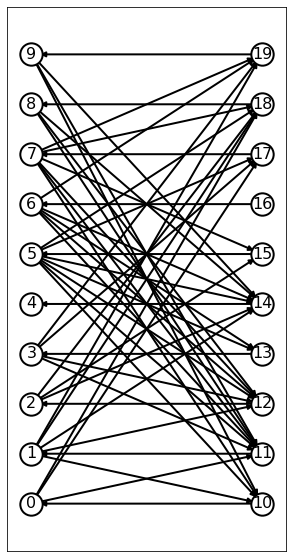

In [5]:
plt.figure(figsize=(5,10))
pos = nx.drawing.layout.bipartite_layout(D, range(size))
nx.draw_networkx_nodes(D, pos=pos, node_size=500, node_color='w', linewidths=2, edgecolors='k')
nx.draw_networkx_edges(D, pos=pos, arrowsize=10, width=2)
nx.draw_networkx_labels(D, pos, font_size=16);

In [6]:
for i in [2,5,9,6,7]:
    D.remove_edge(i+size,i)

In [389]:
list(nx.strongly_connected_components(D)) # if there is only one component there is nothing we can do

[{16},
 {17},
 {19},
 {3},
 {13},
 {15},
 {12},
 {8},
 {18},
 {0},
 {10},
 {1},
 {4},
 {11},
 {14},
 {5},
 {9},
 {2},
 {6},
 {7}]

In [391]:
list(nx.topological_sort(D))

[7, 6, 2, 9, 5, 14, 4, 11, 1, 10, 0, 18, 8, 15, 12, 13, 3, 19, 17, 16]

In [70]:
H = np.zeros_like(A)

In [10]:
A

array([[1, 1, 0, 1, 1, 1, 1, 0, 0, 0],
       [1, 1, 1, 1, 1, 0, 1, 1, 0, 0],
       [1, 1, 1, 0, 0, 1, 0, 0, 0, 0],
       [1, 0, 0, 1, 1, 0, 1, 0, 1, 0],
       [1, 1, 0, 1, 1, 0, 1, 1, 0, 1],
       [0, 0, 1, 1, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 0, 0, 0, 1, 0, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 0, 1, 1],
       [1, 0, 1, 0, 0, 0, 0, 1, 0, 1]])

## Hessenberg ordering
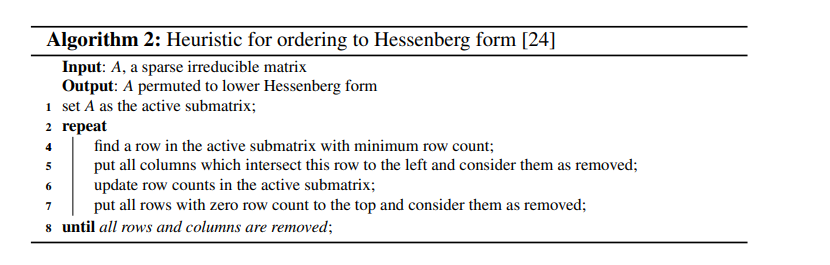

In [7]:
def get_cols(A):
    n,m = A.shape
    idx = A.sum(axis=1).argmin()
    cols = [elt[0] for elt in np.argwhere(A[idx,:] != 0)]
    print(idx, cols)
    lcols = len(cols)
    NA = A[np.ix_([elt for elt in range(n) if elt != idx], [elt for elt in range(m) if elt not in cols])]
    H = A[np.ix_([idx]+[elt for elt in range(n) if elt != idx], cols)]
    return NA, H, cols, idx

In [8]:
def perm(p, r, lc1):
    filtered = [elt for idx, elt in enumerate(r) if idx not in lc1]
    return p+r[lc1].tolist(), np.array(filtered)

In [22]:
def hess(A):
    n,m = A.shape
    l = m
    r = np.array(range(m))
    r2 = np.array(range(n))
    p = []
    NA = A
    cols = []
    rows = []
    while l > 0:
        NA, H, lc, idx = get_cols(NA)
        l -= len(lc)
        print(l)
        cols, r = perm(cols, r, lc)
        rows, r2 = perm(rows, r2, [idx])
    return cols, rows+list(r2)

In [111]:
A = np.array([[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0],
 [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1],
 [0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1]])

In [112]:
print("[{}]".format(";\n".join([" ".join(map(str,elt)) for elt in A])))

[1 0 1 0 0 0 0 0 0 0 0 0 0;
0 1 0 0 0 0 0 1 0 0 0 0 0;
0 0 1 0 1 0 0 0 0 0 0 0 0;
0 0 0 1 0 0 0 0 0 0 1 0 0;
0 0 0 0 1 0 1 0 0 0 0 1 0;
0 0 0 0 0 1 0 0 0 1 0 0 0;
0 0 0 0 0 0 1 0 1 0 0 0 0;
0 0 0 1 0 0 0 1 0 0 0 0 1;
0 1 0 0 0 1 0 0 1 0 0 0 0;
1 0 0 0 0 0 0 0 0 1 0 0 0;
0 0 0 0 0 1 0 0 0 0 1 0 0;
0 0 0 0 0 0 0 0 0 1 0 1 0;
0 0 0 1 0 0 0 0 0 0 0 0 1]


In [81]:
A = np.array([
    [1, 1, 0, 1, 0, 0], 
    [0, 1, 0,0, 0, 0],
    [1, 1, 1, 1, 0, 1],
    [0, 1, 0, 1, 0, 1],
    [0, 0, 1, 1, 1, 0],
    [0, 1, 0, 0, 0, 1]])

In [75]:
order = [0,2,1,3,4,5,6,7,8,9,10,11,12]
H = A[np.ix_(order,order)]
H

array([[1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])

In [82]:
cols,rows = hess(A)

1 [1]
5
4 [4]
4
2 [2]
3
0 [0]
2
0 [0]
1
0 [0]
0


In [83]:
cols, rows

([1, 5, 3, 0, 2, 4], [1, 5, 3, 0, 2, 4])

In [84]:
H = A[np.ix_(rows,cols)]

In [85]:
H

array([[1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0],
       [1, 1, 1, 0, 0, 0],
       [1, 0, 1, 1, 0, 0],
       [1, 1, 1, 1, 1, 0],
       [0, 0, 1, 0, 1, 1]])

In [72]:
H[np.ix_([0,1,2,3,4,5,6,7,8,9,10,11,12],[0,2,3,4,5,6,7,9,10,1,8,11,12])]

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1]])

In [ ]:
Hess[np.ix_(range(10),[0,4,6,7,8,9,1,2,3,5])].astype(int)

In [15]:
NA, H, lc1 = get_cols(A)
NA1, H1, lc2 = get_cols(NA)
NA2, H2, lc3 = get_cols(NA1)
NA3, H3, lc4 = get_cols(NA2)
NA4, H4, lc5 = get_cols(NA3)
NA5, H5, lc6 = get_cols(NA4)

2 [0, 1, 2, 5]
4 [0, 1]
0 [0]
0 [0]
0 [0]
0 [0]


In [14]:
H4

array([[1],
       [0],
       [1],
       [1],
       [1],
       [0]])

In [341]:
H

array([[1, 1, 1, 1],
       [1, 0, 1, 1],
       [1, 1, 0, 0],
       [1, 1, 0, 0],
       [0, 0, 1, 1],
       [0, 0, 1, 1],
       [0, 1, 0, 0],
       [0, 1, 1, 1],
       [0, 0, 1, 1],
       [0, 1, 1, 1]])

In [328]:
r = np.array(range(10))

In [329]:
perm([], r, lc1)

([1, 2, 5, 9], array([0, 3, 4, 6, 7, 8]))

In [330]:
perm(*perm([], r, lc1), lc2)

([1, 2, 5, 9, 0, 4], array([3, 6, 7, 8]))

In [363]:
out = perm(*perm(*perm(*perm(*perm([], r, [1]), [0]), [2]),[1]),[1])
rp = out[0]+list(out[1])

In [360]:
out = perm(*perm(*perm(*perm(*perm([], r, lc1), lc2), lc3),lc4),lc5)
p = out[0]+list(out[1])

In [361]:
p

[[1, 2, 5, 9], [0, 4], [6], [3], [8], 7]

In [364]:
p,rp

([[1, 2, 5, 9], [0, 4], [6], [3], [8], 7],
 [[1], [0], [4], [3], [5], 2, 6, 7, 8, 9])

In [358]:

idx = rp.index(p[0])
rp.remove(idx)

0

In [403]:
tr = [1,4,0,3,8]#2,5,9,6,7]
A[np.ix_(tr,tr)]

array([[1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [1, 1, 1, 0, 0],
       [1, 0, 1, 1, 0],
       [0, 1, 1, 0, 1]])

In [351]:
A[np.ix_(rp,p)]

array([[1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
       [1, 0, 1, 1, 1, 1, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 1, 1, 0, 0, 0],
       [1, 1, 0, 0, 1, 0, 1, 1, 0, 0],
       [0, 0, 1, 1, 1, 1, 0, 0, 1, 0],
       [1, 1, 0, 0, 0, 1, 1, 0, 1, 1],
       [0, 1, 0, 0, 0, 0, 1, 1, 1, 1],
       [0, 1, 1, 1, 0, 0, 1, 1, 0, 1],
       [0, 0, 1, 1, 1, 1, 0, 0, 1, 0],
       [0, 1, 1, 1, 0, 1, 1, 1, 1, 1]])

In [321]:
r = [elt for elt in range(10) if elt not in p]

In [326]:
r

[2, 4, 5, 9]

In [220]:
lc1, np.array(lc2)+len(lc1),np.array(lc3)+len(lc1)+len(lc2),np.array(lc4)+len(lc1)+len(lc2),np.array(lc3)+len(lc1)+len(lc2)

([1, 2, 5, 9], array([11, 13], dtype=int64))

In [191]:
NA4

array([[1],
       [1],
       [1],
       [0],
       [1]])

In [193]:
def concat(H1, H2):
    n1 = H1.shape[0]
    n2, m = H2.shape
    part1 = np.concatenate((np.zeros((n1-n2,m)), H2))
    return np.concatenate((H1, part1), axis=1)

In [205]:
Hess = concat(concat(concat(concat(concat(H, H1), H2), H3), H4),NA4)

In [210]:
Hess.astype(int)

array([[1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
       [1, 0, 1, 1, 1, 1, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 1, 1, 0, 0, 0],
       [1, 1, 0, 0, 1, 0, 1, 1, 0, 0],
       [0, 0, 1, 1, 0, 1, 1, 0, 1, 0],
       [0, 0, 1, 1, 1, 1, 0, 0, 1, 1],
       [0, 1, 0, 0, 0, 0, 1, 1, 1, 1],
       [0, 1, 1, 1, 0, 0, 1, 1, 0, 1],
       [0, 0, 1, 1, 1, 1, 0, 0, 1, 0],
       [0, 1, 1, 1, 0, 1, 1, 1, 1, 1]])

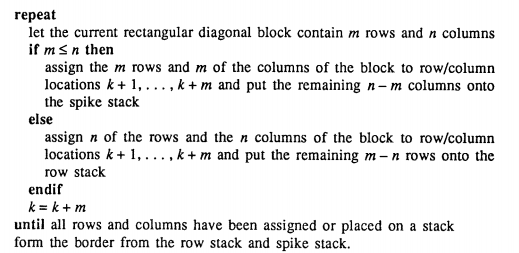

In [211]:
Hess[np.ix_(range(10),[0,4,6,7,8,9,1,2,3,5])].astype(int)

array([[1, 0, 0, 0, 0, 0, 1, 1, 1, 0],
       [1, 1, 0, 0, 0, 0, 0, 1, 1, 1],
       [1, 0, 1, 0, 0, 0, 1, 0, 0, 1],
       [1, 1, 1, 1, 0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 1, 0, 0, 1, 1, 1],
       [0, 1, 0, 0, 1, 1, 0, 1, 1, 1],
       [0, 0, 1, 1, 1, 1, 1, 0, 0, 0],
       [0, 0, 1, 1, 0, 1, 1, 1, 1, 0],
       [0, 1, 0, 0, 1, 0, 0, 1, 1, 1],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1]])

In [79]:
idx = A.sum(axis=1).argmin()
A1 = A[np.ix_([idx]+[elt for elt in range(10) if elt != idx], range(10))]
cols = [elt[0] for elt in np.argwhere(A[idx,:] != 0) if elt[0]>idx]
lcols = len(cols)

In [81]:
H[:,range(lcols)] = A1[:,cols]

In [109]:
np.concatenate(H, np.concatenate([0], H1))

NameError: name 'H1' is not defined

In [85]:
A2 = A1[np.ix_(range(1,10),[elt for elt in range(10) if elt not in cols])]

In [87]:
A2

array([[1, 1, 0, 1, 0, 0, 0],
       [0, 1, 0, 1, 1, 1, 1],
       [1, 1, 1, 0, 1, 0, 0],
       [0, 0, 0, 1, 1, 0, 0],
       [1, 0, 0, 1, 0, 0, 1],
       [0, 0, 1, 0, 1, 1, 1],
       [0, 0, 1, 0, 1, 1, 0],
       [1, 0, 0, 1, 0, 0, 1],
       [0, 0, 1, 1, 1, 1, 1]])

In [88]:
idx = A2.sum(axis=1).argmin()
cols = [elt[0] for elt in np.argwhere(A2[idx,:] != 0) if elt[0]>idx]
lcols2 = len(cols)

In [90]:
H[1:,range(lcols, lcols+lcols2)] = A2[:,cols]

In [36]:
n,m = A2.shape

In [37]:
A3 = A2[np.ix_([elt for elt in range(n) if elt != idx],[elt for elt in range(m) if elt not in cols])]

In [38]:
A3

array([[1, 1, 0, 1, 0, 0],
       [0, 1, 0, 1, 1, 1],
       [1, 1, 1, 0, 0, 0],
       [1, 0, 0, 1, 0, 1],
       [0, 0, 1, 0, 1, 1],
       [0, 0, 1, 0, 1, 0],
       [1, 0, 0, 1, 0, 1],
       [0, 0, 1, 1, 1, 1]])

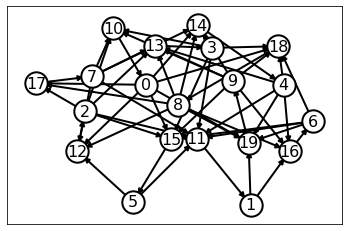

In [97]:
pos = nx.drawing.nx_pydot.graphviz_layout(D, prog='neato')
#plt.figure(figsize=(5,4))
nx.draw_networkx_nodes(D, pos=pos, node_size=500, node_color='w', linewidths=2, edgecolors='k')
nx.draw_networkx_edges(D, pos=pos, arrowsize=10, width=2)
nx.draw_networkx_labels(D, pos, font_size=16);

In [471]:
m = gp.Model('cycles')
m.setParam('OutputFlag', False )
x = m.addVars(range(size), name="match", vtype=GRB.BINARY)

In [472]:
m.setObjective(x.sum(), GRB.MAXIMIZE)

In [475]:
s = 10
counter = 0
exists_scc = True
while counter <= 1000 and exists_scc:
    counter+=1
    m.optimize()
    s = m.objVal
    scc_comps = scc_sol(x)
    exists_scc = len(scc_comps)>0
    for idx, cycle in enumerate(scc_comps):
        g = D.subgraph(cycle)
        nf_cycle = len(cycle)//2 
        M = [key for key, val in x.items() if val.x>=1e-4]
        m.addConstr(gp.quicksum(x[key] for key in M if (key+size,key) in g.edges())<=nf_cycle-1) # the cycle alternates so this is a valid constraint

In [479]:
s

11.0

In [432]:
keep = [key for key, val in x.items() if val.x>=1e-4]
remove = [key for key, val in x.items() if val.x<=1e-4]

In [434]:
Dtemp = D.copy()
for key in remove:
    Dtemp.remove_edge(key+size,key)

In [446]:
remove

[0, 2, 6, 8, 9]

In [445]:
list(nx.topological_sort(Dtemp))

[8, 6, 9, 2, 0, 17, 7, 14, 4, 13, 3, 18, 15, 5, 12, 11, 1, 19, 16, 10]

In [428]:
counter

151

In [404]:
def scc_sol(x):
    Dtemp = D.copy()
    for key, val in x.items():
        if val.x<=1e-4:
            Dtemp.remove_edge(key+size,key)
    return [elt for elt in nx.strongly_connected_components(Dtemp) if len(elt)>1]

In [398]:
scc_sol(x)

10 0
19 9


[{1, 2, 3, 4, 5, 6, 7, 8, 11, 12, 13, 14, 15, 16, 17, 18}]

In [399]:
for idx, cycle in enumerate(scc_sol(x)):
        g = D.subgraph(cycle)
        nf_cycle = len(cycle)//2 
        M = [key for key, val in x.items() if val.x>=1e-4]
        m.addConstr(gp.quicksum(x[key] for key in M if (key+size,key) in g.edges())<=nf_cycle-1) # the cycle alternates so this is a valid constraint

10 0
19 9


In [441]:
colorder = [elt for elt in list(nx.topological_sort(Dtemp)) if elt in range(size)]
roworder = [elt-size for elt in list(nx.topological_sort(Dtemp)) if elt in range(size, 2*size)]

In [442]:
colorder, roworder

([8, 6, 9, 2, 0, 7, 4, 3, 5, 1], [7, 4, 3, 8, 5, 2, 1, 9, 6, 0])

In [452]:
A[np.ix_(roworder,roworder)]

array([[1, 0, 0, 1, 0, 1, 0, 0, 0, 1],
       [1, 1, 0, 1, 0, 0, 0, 1, 0, 1],
       [1, 1, 1, 1, 0, 1, 0, 1, 0, 0],
       [0, 1, 1, 1, 0, 0, 0, 1, 1, 1],
       [0, 0, 1, 0, 1, 1, 0, 1, 1, 1],
       [1, 0, 0, 1, 1, 1, 0, 0, 0, 1],
       [1, 1, 1, 0, 1, 1, 1, 0, 1, 0],
       [0, 1, 0, 1, 0, 0, 1, 1, 1, 1],
       [0, 1, 0, 1, 0, 0, 1, 1, 1, 0],
       [1, 0, 1, 0, 0, 1, 0, 1, 0, 1]])

In [345]:
m.write("myfile.lp")